<b>Kagawa et al. Predicting elevated natriuretic peptide in chest radiography: Emerging utilization gap for artificial intelligence. European Heart Journal - Imaging Methods and Practice, qyae064, https://doi.org/10.1093/ehjimp/qyae064<br>

[Python sample code: the single model (weak learner)] </b><br>
<br>
The sample codes are utilized in Google Colab or Jupyter Notebook.

v1.0.2 July 04, 2024: model_0 available. with GRAD-CAM. non-squared image available.
v1.0.3 July 05, 2024: other models available.

1. If you utilize in Google Colab, mount Google Colab.  
2. Install tensorflow_addons.  
In Google Colab or Jupyter Notebook, either click the arrow on the cell or select the cell and use the appropriate shortcut to execute it (Shift + Enter).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow_addons

2. Import libraries.<br>
Please ignore TFA warning.<br>

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

3. Move or copy the chest radiography image you want to test by specifying the 'image_file_path'.  
Example:  
image_file_path = '/content/drive/MyDrive/image_file.png'

In [2]:
# feature_branch    DELETE in develop or release version

'''
image_file_path = '/content/drive/MyDrive/image_file.png'
'''

#image_file_path = 'C:/Users/egkag/Dropbox/GitHub_public_ekagawa007/Zenodo/MichikoSakamoto91F20220517Cre373Hb115AHF1BNP1518_2.png'
#image_file_path = 'C:/Users/egkag/Dropbox/GitHub_public_ekagawa007/Zenodo/AtsukoSuzawa85F20220519Cre177Hb102BNP2296_resizedSq.png'
image_file_path = 'C:/Users/egkag/Dropbox/GitHub_public_ekagawa007/Zenodo/MichihisaUeda63M20220531Cre069Hb137BNP57.png'

In [ ]:
image_file_path = '/content/drive/MyDrive/image_file.png'

4. Visualize image

Shape of image:  (224, 224, 3)


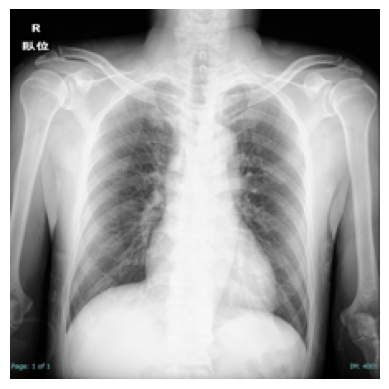

In [3]:
BACKGROUND_COLOR = (0, 0, 0)     #black

# for model_0
target_size = 224
MODEL_NEED_PREPROCESS_INPUT = True
MODEL_PREPROCESS_INPUT = tf.keras.applications.vgg16.preprocess_input
last_conv_layer_name = "block5_conv3"
HEATMAP_SIZE = (14, 14)

def load_and_preprocess_image(path, target_size):   
    try:
        im = Image.open(path).convert("RGB")
        width, height = im.size
        if width > height:
            result = Image.new(im.mode, (width, width), BACKGROUND_COLOR)
            result.paste(im, (0, (width - height) // 2))
        elif width < height:
            result = Image.new(im.mode, (height, height), BACKGROUND_COLOR)
            result.paste(im, ((height - width) // 2, 0))
        else:
            result = im
    except OSError as e:
        pass

    result = result.resize((target_size, target_size))
    image_array = img_to_array(result)

    return image_array

image_array = load_and_preprocess_image(image_file_path, target_size)
print ('Shape of image: ', image_array.shape)

plt. imshow(image_array.astype('uint8'))
plt.axis('off')
plt.show()

5. Save or copy models to 'model_0.h5' to model_path.<br>
Example:<br>
model_path = '/content/drive/MyDrive/model_0.h5'


In [ ]:
# feature_branch     DELETE in develop or release version

'''
model_path = '/content/drive/MyDrive/BNP_CO_200/model_0.h5'
'''

model_path = 'C:/Users/egkag/Dropbox/GitHub_public_ekagawa007/Zenodo/BNP200models/model_0.h5'


In [ ]:
model_path = '/content/drive/MyDrive/BNP_CO_200/model_0.h5'

7. Load model and predict<br>

In [4]:
custom_objects = {"Addons>mish": tfa.activations.mish}
model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
img_array = np.expand_dims(image_array, axis=0)
preprocess_input = MODEL_PREPROCESS_INPUT
tmp_probs = model.predict(preprocess_input(img_array))
print('File: ', image_file_path)
print('Model: ', model_path)
print('The provability of BNP >= 200 pg/mL (single model):', tmp_probs[0][1])

1/1 [==============================] - 2s 2s/step
File:  C:/Users/egkag/Dropbox/GitHub_public_ekagawa007/Zenodo/MichihisaUeda63M20220531Cre069Hb137BNP57.png
Model:  C:/Users/egkag/Dropbox/GitHub_public_ekagawa007/Zenodo/BNP200models/model_0.h5
The provability of BNP >= 200 pg/mL (single model): 0.25471315


8. Show featured map image

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


if MODEL_NEED_PREPROCESS_INPUT == True:
    img_array = preprocess_input(img_array)

model.layers[-1].activation = None

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()


def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    jet = plt.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    display(superimposed_img)

save_and_display_gradcam(image_file_path, heatmap)